In [1]:
import git
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load data from compare-models notebook
episodes = pd.read_pickle("episodes.pkl")
episodes = episodes.assign(family=episodes.protocol)


def protocol(row):
    if row.family == "nakamoto":
        return "nakamoto"
    elif row.family == "bk":
        return f"bk-{row.k}"
    elif row.family == "tailstorm":
        return f"tailstorm-{row.k}-{row.reward}"
    else:
        assert false


episodes = episodes.assign(protocol=episodes.apply(protocol, axis=1))
episodes = episodes.assign(
    protocol=pd.Categorical(
        episodes.protocol,
        categories=sorted(set(episodes.protocol), key=lambda x: x != "nakamoto"),
    )
)
episodes = episodes.assign(
    kind=pd.Categorical(episodes.kind, categories=["trained", "hard-coded"])
)
columns = list(episodes.columns)
columns.remove("family")
columns.insert(1, "family")
episodes = episodes[columns]
episodes = episodes.assign(
    episode_relrew=lambda d: d.episode_reward_attacker
    / (d.episode_reward_attacker + d.episode_reward_defender),
    episode_rpp=lambda d: d.episode_reward_attacker / d.episode_progress,
)
list(episodes.columns)

['protocol',
 'family',
 'k',
 'reward',
 'subblock_selection',
 'alpha',
 'gamma',
 'policy',
 'path',
 'kind',
 'reuse',
 'reused',
 'episode',
 'episode_reward_attacker',
 'episode_reward_defender',
 'episode_progress',
 'episode_chain_time',
 'episode_sim_time',
 'episode_n_steps',
 'episode_n_activations',
 'episode_relrew',
 'episode_rpp']

In [3]:
dict(
    alpha=episodes.alpha.drop_duplicates().sort_values().tolist(),
    gamma=episodes.gamma.drop_duplicates().sort_values().tolist(),
    kind=episodes.kind.drop_duplicates().sort_values().tolist(),
    reuse=episodes.reuse.drop_duplicates().sort_values().tolist(),
    n_episodes=len(episodes.episode.drop_duplicates()),
    n_models=len(episodes.path.drop_duplicates()) - 1,  # minus 1 for NaN
)

{'alpha': [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
 'gamma': [0.05, 0.5, 0.95],
 'kind': ['trained', 'hard-coded'],
 'reuse': ['-', 'gamma05', 'gamma50', 'gamma95', 'proto'],
 'n_episodes': 100,
 'n_models': 594}

In [4]:
setting_key = ["protocol", "family", "k", "subblock_selection", "alpha", "gamma"]
settings = (
    episodes[setting_key]
    .drop_duplicates()
    .sort_values(setting_key)
    .reset_index(drop=True)
)
settings

,protocol,family,k,subblock_selection,alpha,gamma
0,nakamoto,nakamoto,1,n/a,0.20,0.05
1,nakamoto,nakamoto,1,n/a,0.20,0.50
2,nakamoto,nakamoto,1,n/a,0.20,0.95
3,nakamoto,nakamoto,1,n/a,0.25,0.05
4,nakamoto,nakamoto,1,n/a,0.25,0.50
...,...,...,...,...,...,...
79,bk-8,bk,8,n/a,0.45,0.50
80,bk-8,bk,8,n/a,0.45,0.95
81,bk-8,bk,8,n/a,0.50,0.05
82,bk-8,bk,8,n/a,0.50,0.50


In [5]:
trained_episodes = (
    episodes.query('kind == "trained" or (family in ["nakamoto", "tailstorm"])')
    .sort_values(setting_key)
    .reset_index(drop=True)
)
trained_episodes[setting_key + ["policy"]]

,protocol,family,k,subblock_selection,alpha,gamma,policy
0,nakamoto,nakamoto,1,n/a,0.2,0.05,ppo-cut-1a70xyt9-last
1,nakamoto,nakamoto,1,n/a,0.2,0.05,ppo-raw-r8k24psl-best
2,nakamoto,nakamoto,1,n/a,0.2,0.05,ppo-cut-1a70xyt9-best
3,nakamoto,nakamoto,1,n/a,0.2,0.05,ppo-exp-1gnhsv26-best
4,nakamoto,nakamoto,1,n/a,0.2,0.05,ppo-raw-r8k24psl-last
...,...,...,...,...,...,...,...
215995,bk-8,bk,8,n/a,0.5,0.95,ppo-cut-ittori1b-best
215996,bk-8,bk,8,n/a,0.5,0.95,ppo-raw-us6gjrbr-last
215997,bk-8,bk,8,n/a,0.5,0.95,ppo-exp-wuyb02bz-last
215998,bk-8,bk,8,n/a,0.5,0.95,ppo-raw-wa4wz3l0-best


In [6]:
model_key = setting_key + ["policy", "kind"]
models = (
    trained_episodes.groupby(model_key, observed=True)
    .agg(
        n=("episode", len),
        relrew_mean=("episode_relrew", np.mean),
        relrew_std=("episode_relrew", np.std),
        rpp_mean=("episode_rpp", np.mean),
        rpp_std=("episode_rpp", np.std),
    )
    .reset_index()
)
models

,protocol,family,k,subblock_selection,alpha,gamma,policy,kind,n,relrew_mean,relrew_std,rpp_mean,rpp_std
0,nakamoto,nakamoto,1,n/a,0.2,0.05,eyal-sirer-2014,hard-coded,100,0.134661,0.012687,0.134661,0.012687
1,nakamoto,nakamoto,1,n/a,0.2,0.05,honest,hard-coded,100,0.200741,0.008554,0.200741,0.008554
2,nakamoto,nakamoto,1,n/a,0.2,0.05,ppo-cut-1a70xyt9-best,trained,100,0.200742,0.010177,0.200742,0.010177
3,nakamoto,nakamoto,1,n/a,0.2,0.05,ppo-cut-1a70xyt9-last,trained,100,0.200137,0.008838,0.200137,0.008838
4,nakamoto,nakamoto,1,n/a,0.2,0.05,ppo-cut-6zmyzj57-best,trained,100,0.200204,0.008946,0.200204,0.008946
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,bk-8,bk,8,n/a,0.5,0.95,ppo-raw-k4i44aig-last,trained,100,0.957098,0.037564,0.957098,0.037564
2156,bk-8,bk,8,n/a,0.5,0.95,ppo-raw-us6gjrbr-best,trained,100,0.744868,0.292029,0.744868,0.292029
2157,bk-8,bk,8,n/a,0.5,0.95,ppo-raw-us6gjrbr-last,trained,100,0.798543,0.290401,0.798543,0.290401
2158,bk-8,bk,8,n/a,0.5,0.95,ppo-raw-wa4wz3l0-best,trained,100,0.582089,0.181511,0.582089,0.181511


In [7]:
best_models = models.loc[
    models.groupby(setting_key + ["kind"], observed=True).rpp_mean.idxmax()
]
best_models_episodes = pd.merge(
    best_models[model_key], episodes, on=model_key, how="left"
)

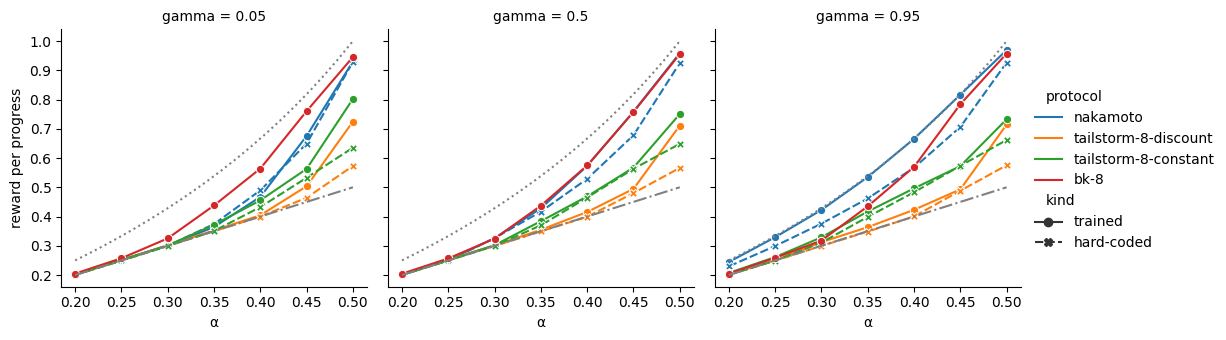

In [8]:
fig = sns.relplot(
    kind="line",
    # data = best_models_episodes,
    # y = 'episode_rpp',
    data=best_models,
    y="rpp_mean",
    x="alpha",
    col="gamma",
    hue="protocol",
    style="kind",
    markers=True,
    height=3.5,
    aspect=1,
)
fig.set(ylabel="reward per progress", xlabel="α")
for ax in fig.axes.flatten():
    alpha = np.linspace(min(best_models.alpha), max(best_models.alpha), 20)
    ax.plot(alpha, alpha, linestyle="dashdot", color="gray")
    ax.plot(alpha, alpha / (1 - alpha), linestyle="dotted", color="gray")


fig.savefig(
    "reward_per_progress_rl.png",
    dpi=600,
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
)